# Where does linear regression fail?

In [1]:
import numpy as np
from pyglmnet import GLM
import matplotlib.pyplot as plt
% matplotlib inline

/Users/pavanramkumar/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(labelsize=14)

In [3]:
def kldiv(P, Q):
    eps = 1e-6
    kld = 0.5 * np.sum(P * np.log(eps + P / (eps + Q))) + \
          0.5 * np.sum(Q * np.log(eps + Q / (eps + P)))
    return kld

## Let's simulate a couple of neurons

### Simulate the covariates

In [4]:
n_samples = 1000
n_predictors = 1
X_train = np.random.randn(n_samples, n_predictors)
X_test = np.random.randn(n_samples, n_predictors)

### Specify two different neurons

In [5]:
# A low dynamic range neuron
neuron1 = dict()
neuron1['beta0'] = 0.1
neuron1['beta'] = [0.3]

# A high dynamic range neuron
neuron2 = dict()
neuron2['beta0'] = 0.1
neuron2['beta'] = [1.5]

### Simulate the spike counts

In [6]:
glm_simulator = GLM(distr='poissonexp')
y1_train = glm_simulator.simulate(neuron1['beta0'], neuron1['beta'], X_train)
y2_train = glm_simulator.simulate(neuron2['beta0'], neuron2['beta'], X_train)

y1_test = glm_simulator.simulate(neuron1['beta0'], neuron1['beta'], X_test)
y2_test = glm_simulator.simulate(neuron2['beta0'], neuron2['beta'], X_test)

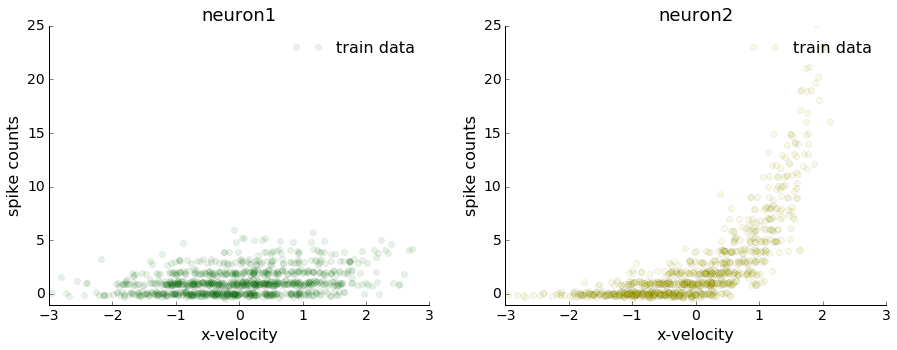

In [7]:
plt.figure(figsize=(15,5))
ax = plt.subplot(121)
simpleaxis(ax)
plt.plot(X_train, y1_train + 0.15*np.random.randn(y1_train.shape[0]), 'go', alpha=0.1)
plt.xlabel('x-velocity', fontsize=16)
plt.ylabel('spike counts', fontsize=16)
plt.title('neuron1', fontsize=18)
plt.legend(['train data'], frameon=False, fontsize=16)
plt.xlim([-3, 3])
plt.ylim([-1, 25])

ax = plt.subplot(122)
simpleaxis(ax)
plt.plot(X_train, y2_train + 0.15*np.random.randn(y2_train.shape[0]), 'yo', alpha=0.1)
plt.xlabel('x-velocity', fontsize=16)
plt.ylabel('spike counts', fontsize=16)
plt.title('neuron2', fontsize=18)
plt.legend(['train data'], frameon=False, fontsize=16)
plt.xlim([-3, 3])
plt.ylim([-1, 25])
plt.show()

## neuron1: Linear vs. Poisson

In [8]:
# -------- Linear -----------
glm_estimate_linear = GLM(distr='normal', reg_lambda=[0.])
# Fit
glm_estimate_linear.fit(X_train, y1_train)
# Predict
y1_test_hat_linear = glm_estimate_linear[0].predict(X_test)
# Generate samples
y1_test_generate_linear = glm_estimate_linear.simulate(glm_estimate_linear[0].fit_['beta0'],
                                         glm_estimate_linear[0].fit_['beta'],
                                         X_test)

# -------- Poisson -----------
glm_estimate_poisson = GLM(distr='poissonexp', reg_lambda=[0.])
# Fit
glm_estimate_poisson.fit(X_train, y1_train)
# Predict
y1_test_hat_poisson = glm_estimate_poisson[0].predict(X_test)
# Generate samples
y1_test_generate_poisson = glm_estimate_poisson.simulate(glm_estimate_poisson[0].fit_['beta0'],
                                         glm_estimate_poisson[0].fit_['beta'],
                                         X_test)

### Compare model fits

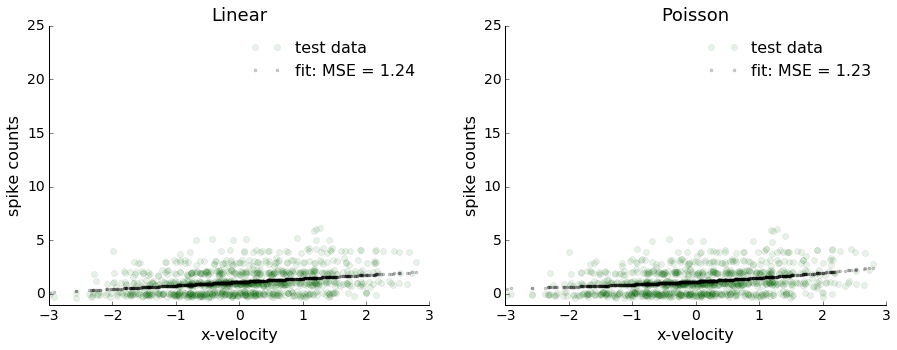

In [9]:
# Visualize Linear
plt.figure(figsize=(15,5))
ax = plt.subplot(121)
simpleaxis(ax)
plt.plot(X_test, y1_test + 0.15*np.random.randn(y1_test.shape[0]), 'go', alpha=0.1)
plt.plot(X_test, y1_test_hat_linear, 'k.', alpha=0.2)
plt.xlabel('x-velocity', fontsize=16)
plt.ylabel('spike counts', fontsize=16)
plt.title('Linear', fontsize=18)
plt.legend(['test data', 'fit: MSE = %4.2f' % np.mean((y1_test - y1_test_hat_linear) ** 2)], frameon=False, fontsize=16)
plt.xlim([-3, 3])
plt.ylim([-1, 25])

# Visualize Poisson
ax = plt.subplot(122)
simpleaxis(ax)
plt.plot(X_test, y1_test + 0.15*np.random.randn(y1_test.shape[0]), 'go', alpha=0.1)
plt.plot(X_test, y1_test_hat_poisson, 'k.', alpha=0.2)
plt.xlabel('x-velocity', fontsize=16)
plt.ylabel('spike counts', fontsize=16)
plt.title('Poisson', fontsize=18)
plt.legend(['test data', 'fit: MSE = %4.2f' % np.mean((y1_test - y1_test_hat_poisson) ** 2)], frameon=False, fontsize=16)
plt.xlim([-3, 3])
plt.ylim([-1, 25])
plt.show()

### Compare generated samples

In [10]:
# Histograms
[y1_test_counts, y1_test_bin_edges] = np.histogram(y1_test, bins=22, range=[-2, 20])
[y1_test_generate_linear_counts, y1_test_bin_edges] = np.histogram(y1_test_generate_linear, bins=22, range=[-2, 20])
[y1_test_generate_poisson_counts, y1_test_bin_edges] = np.histogram(y1_test_generate_poisson, bins=22, range=[-2, 20])

# KL Divergence
kldiv_linear = kldiv(y1_test_counts, y1_test_generate_linear_counts)
kldiv_poisson = kldiv(y1_test_counts, y1_test_generate_poisson_counts)

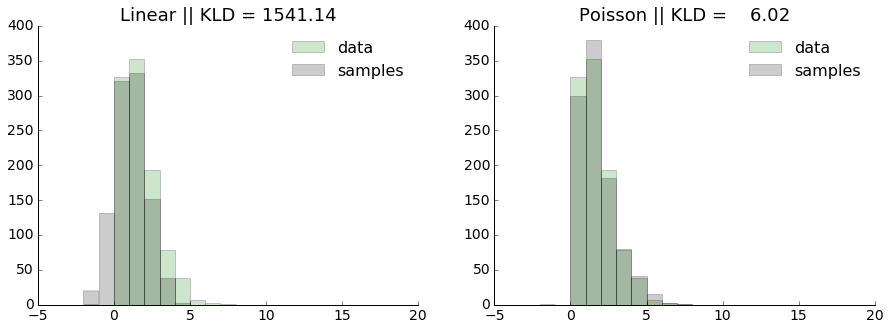

In [11]:
# Visualize Linear
plt.figure(figsize=(15,5))
ax = plt.subplot(121)
simpleaxis(ax)
plt.hist(y1_test, bins=22, range=[-2, 20], color='g', alpha=0.2)
plt.hist(y1_test_generate_linear, bins=22, range=[-2, 20], color='k', alpha=0.2)
plt.ylim([0, 400])
plt.title('Linear || KLD = %7.2f' % kldiv_linear, fontsize=18)
plt.legend(['data', 'samples'], frameon=False, fontsize=16)
# Visualize Poisson
ax = plt.subplot(122)
simpleaxis(ax)
plt.hist(y1_test, bins=22, range=[-2, 20], color='g', alpha=0.2)
plt.hist(y1_test_generate_poisson, bins=22, range=[-2, 20], color='k', alpha=0.2)
plt.ylim([0, 400])
plt.title('Poisson || KLD = %7.2f' % kldiv_poisson, fontsize=18)
plt.legend(['data', 'samples'], frameon=False, fontsize=16)
plt.show()


## neuron 2: Linear vs. Poisson

In [12]:
# -------- Linear -----------
glm_estimate_linear = GLM(distr='normal', reg_lambda=[0.])
# Fit
glm_estimate_linear.fit(X_train, y2_train)
# Predict
y2_test_hat_linear = glm_estimate_linear[0].predict(X_test)
# Generate samples
y2_test_generate_linear = glm_estimate_linear.simulate(glm_estimate_linear[0].fit_['beta0'],
                                         glm_estimate_linear[0].fit_['beta'],
                                         X_test)

# -------- Poisson -----------
glm_estimate_poisson = GLM(distr='poissonexp', reg_lambda=[0.])
# Fit
glm_estimate_poisson.fit(X_train, y2_train)
# Predict
y2_test_hat_poisson = glm_estimate_poisson[0].predict(X_test)
# Generate samples
y2_test_generate_poisson = glm_estimate_poisson.simulate(glm_estimate_poisson[0].fit_['beta0'],
                                         glm_estimate_poisson[0].fit_['beta'],
                                         X_test)

### Compare model fits

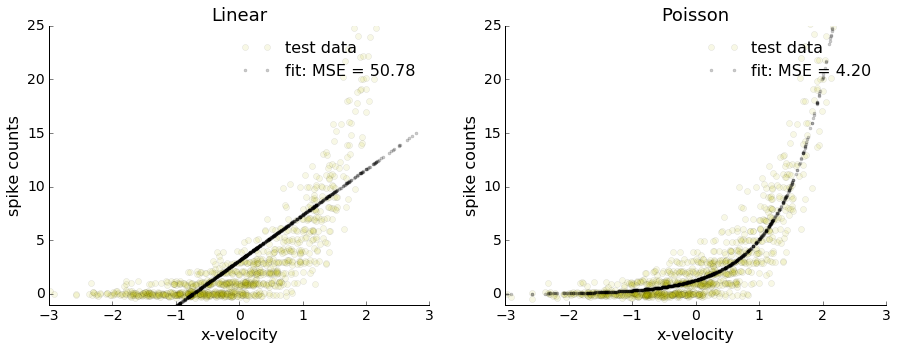

In [13]:
# Visualize Linear
plt.figure(figsize=(15,5))
ax = plt.subplot(121)
simpleaxis(ax)
plt.plot(X_test, y2_test + 0.15*np.random.randn(y2_test.shape[0]), 'yo', alpha=0.1)
plt.plot(X_test, y2_test_hat_linear, 'k.', alpha=0.2)
plt.xlabel('x-velocity', fontsize=16)
plt.ylabel('spike counts', fontsize=16)
plt.title('Linear', fontsize=18)
plt.legend(['test data', 'fit: MSE = %4.2f' % np.mean((y2_test - y2_test_hat_linear) ** 2)], frameon=False, fontsize=16)
plt.xlim([-3, 3])
plt.ylim([-1, 25])

# Visualize Poisson
ax = plt.subplot(122)
simpleaxis(ax)
plt.plot(X_test, y2_test + 0.15*np.random.randn(y2_test.shape[0]), 'yo', alpha=0.1)
plt.plot(X_test, y2_test_hat_poisson, 'k.', alpha=0.2)
plt.xlim([-3, 3])
plt.xlabel('x-velocity', fontsize=16)
plt.ylabel('spike counts', fontsize=16)
plt.title('Poisson', fontsize=18)
plt.legend(['test data', 'fit: MSE = %4.2f' % np.mean((y2_test - y2_test_hat_poisson) ** 2)], frameon=False, fontsize=16)
plt.ylim([-1, 25])
plt.show()

### Compare generated samples

In [14]:
# Histograms
[y2_test_counts, y2_test_bin_edges] = np.histogram(y2_test, bins=22, range=[-2, 20])
[y2_test_generate_linear_counts, y2_test_bin_edges] = np.histogram(y2_test_generate_linear, bins=22, range=[-2, 20])
[y2_test_generate_poisson_counts, y2_test_bin_edges] = np.histogram(y2_test_generate_poisson, bins=22, range=[-2, 20])

# KL Divergence
kldiv_linear = kldiv(y2_test_counts, y2_test_generate_linear_counts)
kldiv_poisson = kldiv(y2_test_counts, y2_test_generate_poisson_counts)

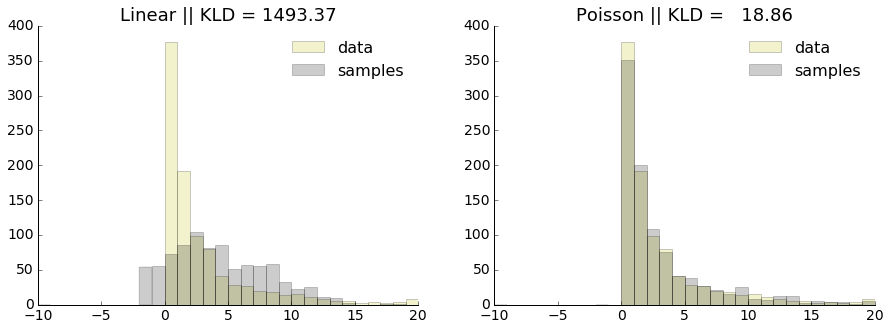

In [15]:
# Visualize Linear
plt.figure(figsize=(15,5))
ax = plt.subplot(121)
simpleaxis(ax)
plt.hist(y2_test, bins=30, range=[-10, 20], color='y', alpha=0.2)
plt.hist(y2_test_generate_linear, bins=22, range=[-2, 20], color='k', alpha=0.2)
plt.ylim([0, 400])
plt.title('Linear || KLD = %7.2f' % kldiv_linear, fontsize=18)
plt.legend(['data', 'samples'], frameon=False, fontsize=16)
# Visualize Poisson
ax = plt.subplot(122)
simpleaxis(ax)
plt.hist(y2_test, bins=30, range=[-10, 20], color='y', alpha=0.2)
plt.hist(y2_test_generate_poisson, bins=22, range=[-2, 20], color='k', alpha=0.2)
plt.ylim([0, 400])
plt.title('Poisson || KLD = %7.2f' % kldiv_poisson, fontsize=18)
plt.legend(['data', 'samples'], frameon=False, fontsize=16)
plt.show()
